# Logistic Regression

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
sns.set_context("notebook")

from matplotlib import pyplot as plt
%matplotlib inline

## Dataset
Create a simple dataset that can be used for classification.

In [2]:
num_points = 500
x1 = np.random.randn(num_points)
x2 = np.random.randn(num_points)
y = np.random.randint(2, size=num_points)
# y.reshape(-1,1)
x1[y == 0] = x1[y == 0] + 3
x2[y == 0] = x2[y == 0] + 5

In [3]:
df = pd.DataFrame({'y':y, 'x1':x1, 'x2':x2})

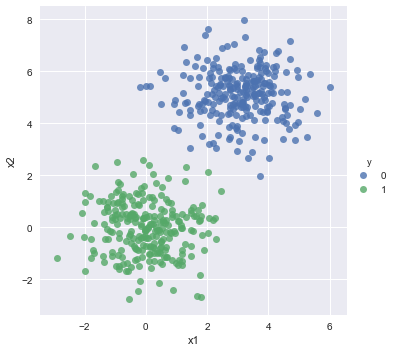

In [4]:
sns.lmplot(x='x1', y='x2', data=df, hue='y', fit_reg=False)

# Features and Labels
Split Dataframe into features and labels

In [5]:
y_array = df.loc[:,'y'].values
X_array = df.loc[:,['x1', 'x2']].values

### One hot vector
Convert labels format to one hot vectors.

In [6]:
def dense_to_one_hot(labels_dense, num_classes=2):
    labels_one_hot = []
    for label in labels_dense:
        indices = [0]*num_classes
        indices[label] = 1
        labels_one_hot.append(indices)
    
    return labels_one_hot

In [7]:
y_one_hot = dense_to_one_hot(y_array, 2)
y_one_hot[0:5]

[[0, 1], [0, 1], [1, 0], [1, 0], [1, 0]]

Split into training set and test set.

In [8]:
import sklearn
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_array, y_one_hot, test_size=0.2, random_state=42)

### Batches
Define function to take random batches from the training set during training.

In [10]:
def make_batch(X, y, batch_size):
    
    y_size = len(y)
    index_sample = np.random.choice(y_size, batch_size, replace=False)
    # print("index_sample: {}".format(index_sample))
    y_array = np.array(y)
    
    X_batch = X[index_sample]
    y_batch = y_array[index_sample]
    
    return X_batch, y_batch

## Tensor Flow

In [11]:
import tensorflow as tf

In [12]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

In [13]:
# Reset graph is session isn't closed
reset_graph()

### Define hyperparameters

In [14]:
batch_size = X_train.shape[0] // 10
num_features = X_train.shape[1]
num_classes = len(df.loc[:,'y'].unique())
learning_rate = 0.005
epochs = 1000
epochs_to_print = epochs // 10

### Define placeholders

In [15]:
X = tf.placeholder(tf.float32, [None, num_features])
y_ = tf.placeholder(tf.float32, [None, num_classes])

### TensorFlow Graph
Use functions to create TensorFlow graph.

#### Softmax Layer

In [16]:
def softmax_layer(X_tensor, num_classes, num_features):
    W = tf.Variable(tf.zeros([num_features, num_classes]))
    b = tf.Variable(tf.zeros([num_classes]))
    y = tf.nn.softmax(tf.matmul(X_tensor, W) + b)
    return y

In [17]:
y = softmax_layer(X, num_classes, num_features)

#### Cost Function

In [18]:
def cost_function(y, y_):
    cost = -tf.reduce_mean(y_ * tf.log(y))
    return cost

In [19]:
cost = cost_function(y, y_)

#### Training Step

In [20]:
def train(cost, learning_rate):
    training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    return training_step

In [21]:
training_step = train(cost, learning_rate)

#### Accuracy

In [22]:
def compute_accuracy(y, y_):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    return accuracy

In [23]:
accuracy = compute_accuracy(y, y_)

### Train the Model

In [24]:
with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for i in range(epochs):
        
        X_batch, y_batch = make_batch(X_train, y_train, batch_size)
        sess.run(training_step, feed_dict={X: X_batch, y_: y_batch})
        current_cost = sess.run(cost, feed_dict={X: X_batch, y_: y_batch})
        
        # Print average cost periodically
        if i % epochs_to_print == 0:
            print("Epoch: {:4d}, current cost = {:0.3f}".format(i, current_cost))

    print("Finished training model.")
    
    X_batch, y_batch = make_batch(X_test, y_test, batch_size)
    print("Final accuracy = {:0.3f}".format(sess.run(accuracy, feed_dict={X: X_test, y_: y_test})))

Epoch:    0, current cost = 0.340
Epoch:  100, current cost = 0.207
Epoch:  200, current cost = 0.200
Epoch:  300, current cost = 0.204
Epoch:  400, current cost = 0.173
Epoch:  500, current cost = 0.170
Epoch:  600, current cost = 0.142
Epoch:  700, current cost = 0.157
Epoch:  800, current cost = 0.090
Epoch:  900, current cost = 0.123
Finished training model.
Final accuracy = 0.960
